Based on:  
https://www.tensorflow.org/datasets/keras_example  
https://www.tensorflow.org/tutorials/images/data_augmentation  


In [27]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

from frouros.detectors.data_drift import MMD

# MNIST input pipeline

In [42]:
(ds_train, ds_test), metadata = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

INFO:absl:Load dataset info from /home/borja/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/home/borja/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split ['train', 'test'], from /home/borja/tensorflow_datasets/mnist/3.0.1


In [43]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(metadata.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [44]:
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

# Create image encoder

In [63]:
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(input_shape=(28, 28)),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim=64)

In [65]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [66]:
encoder_train = ((x, x) for x, _ in ds_train)
encoder_test = ((x, x) for x, _ in ds_test)
autoencoder.fit(encoder_test, epochs=10, validation_data=encoder_test)

Epoch 1/10
     72/Unknown - 1s 3ms/step - loss: 0.0992

StopIteration: 

# Create and train the model

In [21]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [22]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
model.fit(ds_train, epochs=6, validation_data=ds_test)

Epoch 1/6
469/469 [==============================] - 3s 3ms/step - loss: 0.3600 - sparse_categorical_accuracy: 0.9012 - val_loss: 0.1968 - val_sparse_categorical_accuracy: 0.9418
Epoch 2/6
469/469 [==============================] - 1s 3ms/step - loss: 0.1682 - sparse_categorical_accuracy: 0.9521 - val_loss: 0.1393 - val_sparse_categorical_accuracy: 0.9595
Epoch 3/6
469/469 [==============================] - 1s 3ms/step - loss: 0.1214 - sparse_categorical_accuracy: 0.9650 - val_loss: 0.1114 - val_sparse_categorical_accuracy: 0.9678
Epoch 4/6
469/469 [==============================] - 2s 3ms/step - loss: 0.0950 - sparse_categorical_accuracy: 0.9724 - val_loss: 0.1015 - val_sparse_categorical_accuracy: 0.9706
Epoch 5/6
469/469 [==============================] - 1s 3ms/step - loss: 0.0764 - sparse_categorical_accuracy: 0.9782 - val_loss: 0.0875 - val_sparse_categorical_accuracy: 0.9735
Epoch 6/6
469/469 [==============================] - 1s 3ms/step - loss: 0.0630 - sparse_categorical_accu

# Data augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomRotation(0.3),
])

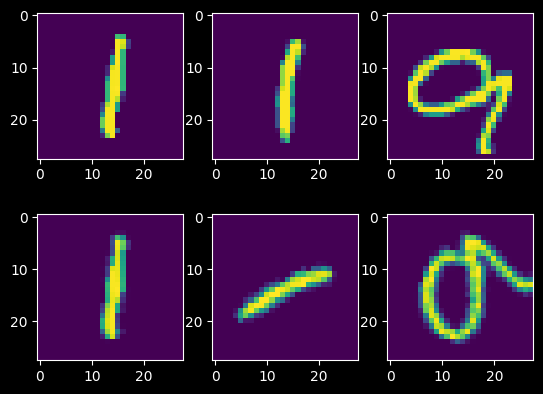

In [14]:
images, labels = next(iter(ds_train))
images = images.numpy()
labels = labels.numpy()
augmented_images = data_augmentation(images).numpy()
fig, ax = plt.subplots(nrows=2, ncols=3)

for i in range(ax.shape[1]):
    ax[0,i].imshow(images[i])
    ax[1,i].imshow(augmented_images[i])


# Data drift detection 

A significance level of $\alpha = 0.05$ is set to perform the hypothesis test.


In [9]:
alpha = 0.05

Maximum Mean Discrepancy (MMD) {cite:p}`JMLR:v13:gretton12a` imported from Frouros is used with a Radial Basis Function kernel (RBF), set by default in MMD. In addition to calculating the corresponding MMD statistic, p-value is estimated using permutation test.

In [15]:
detector = MMD()
_ = detector.fit(X=images.reshape(images.shape[0], -1))

Compare each test dataset to the dataset fitted by MMD.


In [18]:
result, _ = detector.compare(X=augmented_images.reshape(images.shape[0], -1))
result.distance

-0.0003563507539910905

In [17]:
drift = result.distance > alpha
drift

False